## Geospatial Analytics for Adventure Tourism in Colorado

## Introduction
This project leverages data science and geospatial analytics to identify, analyze, and visualize key recreational locations across Colorado. Our objective was to support strategic planning for adventure-based tourism by evaluating suitable destinations for a variety of outdoor activities.

### Project Plan and Methodology
We began by defining a set of eight representative locations across Colorado. These were selected based on several key criteria:

- Activity Suitability: Each location was matched with one or more outdoor sports such as hiking, white-water rafting, rock climbing, mountain biking, skiing, or kayaking.
- Geographic Distribution: Locations were spread across different regions of Colorado to ensure spatial diversity and statewide coverage.
- Elevation and Terrain: Elevation data was included to reflect terrain difficulty and activity relevance (e.g., higher elevations for alpine skiing, varied terrain for hiking).
- Accessibility and Connectivity: We factored in relative distances between sites to evaluate route efficiency and optimize travel paths for multi-activity trip planning.

### Data Parameters Collected
For each site, we recorded:
- City Name / Region
- Latitude and Longitude
- Elevation (ft)
- Estimated Travel Distance Between Locations
- Activity Type(s) associated with each location

### Visualization and Analysis
We used Python libraries such as Folium to generate interactive geographic maps and Plotly for advanced visualizations including elevation profiles, activity distribution charts, and density heatmaps. These visual tools enabled us to:
- Map spatial patterns of activities
- Analyze terrain variation
- Simulate travel routes between adventure spots
- Highlight high-density recreation areas

This approach demonstrates how data science can be used to support informed decision-making in outdoor recreation planning by integrating geographic, environmental, and recreational criteria into a unified analytical framework.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import numpy as np
import json 
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
import folium
from folium import plugins


In [2]:
data = pd.read_json("July code jam.json")
data

location_name                           trail_name        sport type  \
0  Rocky Mountain NP                       Bear Lake Loop            Hiking   
1       Maroon Bells        Maroon Lake Scenic Loop Trail            Hiking   
2            Boulder                     Chautauqua Trail            Hiking   
3   Colorado Springs                 Buffalo Canyon Trail            Hiking   
4            Durango                      Spud Lake Trail  Hiking & Fishing   
5   Glenwood Springs  Grizzly Creek Trail (first 2 miles)            Hiking   
6     Grand Junction                     Riverfront Trail   Hiking & Biking   
7       Fort Collins         Riverbend Ponds Natural Area            Hiking   

   latitude  longitude difficulty_level elevation_gain entrance_pass  \
0  40.31196 -105.64581         Beginner          45 ft           Yes   
1  39.09991 -106.94192         Beginner         160 ft           yes   
2  40.00080 -105.28360         Beginner         200 ft            No   
3  38.81100 -104.85990         Beginner         150 ft            No   
4  37.42860 -107.77940         Beginner         100 ft            No   
5  39.44750 -107.33000         Beginner         200 ft            No   
6  39.07420 -108.55060         Beginner        Minimal            No   
7  40.54560 -105.01290         Beginner        Minimal            No   

  gear_needed camping  
0          No     Yes  
1          No     Yes  
2          No      No  
3          No      No  
4          No     Yes  
5          No      No  
6          No      No  
7          No      No

In [3]:
data.columns

Index(['location_name', 'trail_name', 'sport type', 'latitude', 'longitude',
       'difficulty_level', 'elevation_gain', 'entrance_pass', 'gear_needed',
       'camping'],
      dtype='object')

### Data visualization

In [4]:
#Elevation Profile (Line Chart)
import pandas as pd
import plotly.express as px

# Create DataFrame with elevation added (in feet)
places = [
    {"City": "Boulder", "Latitude": 40.0008, "Longitude": -105.2836, "Elevation": 5430},
    {"City": "Colorado Springs", "Latitude": 38.8110, "Longitude": -104.8599, "Elevation": 6035},
    {"City": "Durango", "Latitude": 37.4286, "Longitude": -107.7794, "Elevation": 6512},
    {"City": "Glenwood Springs", "Latitude": 39.4475, "Longitude": -107.3300, "Elevation": 5761},
    {"City": "Grand Junction", "Latitude": 39.0742, "Longitude": -108.5506, "Elevation": 4600},
    {"City": "Fort Collins", "Latitude": 40.5456, "Longitude": -105.0129, "Elevation": 5003},
    {"City": "Estes Park (Rocky Mountain NP)", "Latitude": 40.31196, "Longitude": -105.64581, "Elevation": 7522},
    {"City": "Aspen (Maroon Bells)", "Latitude": 39.09991, "Longitude": -106.94192, "Elevation": 8000}
]

df = pd.DataFrame(places)

# Sort by Elevation
df_sorted = df.sort_values(by='Elevation')

# Create elevation profile
fig = px.line(
    df_sorted,
    x='City',
    y='Elevation',
    title='Elevation Profile of Colorado Activity Locations',
    markers=True,
    template='plotly_dark'
)

fig.update_traces(line=dict(color='lightgreen'))
fig.update_layout(xaxis_tickangle=-45)
fig.show()


#### The elevation increase from Grand Junction to Aspen indicates a transition from lower valley terrain to higher mountainous regions. This rising elevation reflects the shift into the heart of the Colorado Rockies, suggesting more challenging terrain and potentially more suitable conditions for alpine activities such as skiing, hiking, and mountain biking. Understanding this elevation gradient is essential for planning routes and selecting appropriate recreational activities based on terrain difficulty and altitude.

In [5]:
import plotly.express as px
import pandas as pd

# Reuse or recreate the same data
places= [
    {"City": "Boulder", "Latitude": 40.0008},
    {"City": "Colorado Springs", "Latitude": 38.8110},
    {"City": "Durango", "Latitude": 37.4286},
    {"City": "Glenwood Springs", "Latitude": 39.4475},
    {"City": "Grand Junction", "Latitude": 39.0742},
    {"City": "Fort Collins", "Latitude": 40.5456},
    {"City": "Estes Park", "Latitude": 40.31196},
    {"City": "Aspen", "Latitude": 39.09991},
]
df = pd.DataFrame(places)

# Define regions
df["Region"] = df["Latitude"].apply(lambda x: "North Colorado" if x > 39.5 else "South Colorado")

# Create the sunburst chart
fig = px.sunburst(
    df,
    path=['Region', 'City'],
    values=[1]*len(df),
    title='Colorado Activity Locations: Sunburst by Region and City',
    template='plotly_dark'
)

fig.show()

### This code creates a sunburst chart to visualize key recreational cities in Colorado, grouped by geographic region. Using latitude data, each city is classified as either North Colorado or South Colorado. The chart is built with Plotly Express and displays a hierarchical view where regions form the outer ring and cities form the inner segments. This visualization helps highlight the spatial distribution of activity locations across the state in an intuitive and interactive format.

#### Calculations of the distance between two locations

In [6]:
from math import radians, sin, cos, sqrt, atan2 

def haversine(lat1, lon1, lat2, lon2):
    R= 6371 # Earth radius
        # convert degree in radians
    lat1, lon1, lat2, lon2 = map(radians,[lat1, lon1, lat2, lon2])

    dlat= lat2- lat1
    dlon= lon2 - lon1

        #haversine formula
    a= sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2* atan2(sqrt(a), sqrt(1-a))
    distance= R * c

    return distance

## Base route model calculation 

In [7]:

dist_km1 =  haversine(40.31196, -105.64581, 39.09991, -106.94192)
print ("Distance between Bear Lake Loop to Maroon Lake Scenic Loop Trail:", dist_km1)

dist_km2= haversine(39.09991, -106.94192, 40.0008, -105.2836 )
print ("Distance between Maroon Lake Scenic Loop Trail to Chautauqua Trail:",dist_km2) 

dist_km3 = haversine(40.0008, -105.2836, 38.8110,-104.8599)
print ("Distance between Chautauqua Trail to Buffalo Canyon Trail:", dist_km3) 

dist_km4 = haversine(38.8110,-104.8599, 37.4286,-107.7794)
print ("Distance between Buffalo Canyon Trail to Spud Lake Trail:", dist_km4) 

dist_km5 = haversine(37.4286,-107.7794, 39.4475, -107.33 )
print ("Distance between Spud Lake Trail to Grizzly Creek Trail:", dist_km5)

dist_km6 = haversine(39.4475, -107.33, 39.0742, -108.5506 )
print ("Distance between Grizzly Creek Trail to Riverfront Trail:", dist_km6) 

dist_km7 = haversine(39.0742, -108.5506, 40.5456, -105.0129 )
print ("Distance between Riverfront Trail to Riverbend Ponds Natural Area :", dist_km7) 

dist_km8 = haversine(40.5456, -105.0129, 40.31196, -105.64581 )
print ("Distance between Riverbend Ponds Natural Area to Bear Lake Loop :", dist_km8) 

base_total_distance = dist_km1 + dist_km2 + dist_km3 + dist_km4 + dist_km5 + dist_km6 + dist_km7 + dist_km8
base_total_distance

print("Total distance for base route:",base_total_distance)


Distance between Bear Lake Loop to Maroon Lake Scenic Loop Trail: 174.51666194644122
Distance between Maroon Lake Scenic Loop Trail to Chautauqua Trail: 173.92174775753992
Distance between Chautauqua Trail to Buffalo Canyon Trail: 137.2160507087949
Distance between Buffalo Canyon Trail to Spud Lake Trail: 298.0628305021433
Distance between Spud Lake Trail to Grizzly Creek Trail: 227.87713261122263
Distance between Grizzly Creek Trail to Riverfront Trail: 112.9874602617566
Distance between Riverfront Trail to Riverbend Ponds Natural Area : 343.589901946269
Distance between Riverbend Ponds Natural Area to Bear Lake Loop : 59.53828891552769
Total distance for base route: 1527.7100746496953


## Base Hiking Route Model


### Base route model creation 
The base model calculates the total distance of a predefined hiking route that connects seven popular trails in Colorado. Unlike the optimized model, which dynamically determines the most efficient path, this approach follows a fixed sequence of locations. The goal is to establish a benchmark for comparison with the optimized route.
Libraries Used fof this model is Haversine. It is library-based function used to calculate the great-circle distance between two geographic coordinates. This metric is ideal for measuring real-world travel distances over the Earth's surface. The base model uses a straightforward, linear approach. Each pair of consecutive hiking locations is manually defined.The Haversine formula is applied to compute the distance between each pair.
All segment distances are summed to calculate the total route length. The route will end at starting point.
Route Sequence as follows:
The route includes the following trails in order:
Bear Lake Loop → Maroon Lake Scenic Loop Trail
Maroon Lake Scenic Loop Trail → Chautauqua Trail
Chautauqua Trail → Buffalo Canyon Trail
Buffalo Canyon Trail → Spud Lake Trail
Spud Lake Trail → Grizzly Creek Trail
Grizzly Creek Trail → Riverfront Trail
Riverfront Trail → Riverbend Ponds Natural Area
Riverbend Ponds Natural Area  → Bear Lake Loop.
The base model does not involve route optimization. It serves as a control or baseline for evaluating the effectiveness of more advanced algorithms. The simplicity of this approach makes it easy to implement and interpret, but it may not yield the shortest possible path. The base model was chosen to provide a reference point for comparison. By calculating the total distance of a fixed route, we can assess how much improvement is achieved through optimization techniques like the nearest-neighbor algorithm.
The total distance of the base route is calculated in kilometers using the Haversine formula. This value serves as a benchmark against which the optimized model’s performance can be measured.

### Different hiking route a user can take to plan his trip if he is planning to cover only 3 hiking trails

In [8]:

sample_dist_1 = dist_km1 + dist_km2 
print( "Route A:",sample_dist_1) 

sample_dist_2 = dist_km2  + dist_km3
print( "Route B:", sample_dist_2)

sample_dist_3 = dist_km3 + dist_km4
print( "Route C:", sample_dist_3)

sample_dist_4 =dist_km4 + dist_km5
print( "Route D:", sample_dist_4)

sample_dist_5 = dist_km5 + dist_km6
print( "Route E:", sample_dist_5)

sample_dist_6 =dist_km6 + dist_km7
print( "Route F:", sample_dist_6)

sample_dist_7 =dist_km7 + dist_km1
print( "Route G:", sample_dist_7)


Route A: 348.43840970398116
Route B: 311.13779846633486
Route C: 435.2788812109382
Route D: 525.9399631133659
Route E: 340.86459287297924
Route F: 456.5773622080256
Route G: 518.1065638927103


#### Different Route combinations
#### Route A = Bear Lake Loop → Maroon Lake Scenic Loop Trail → Chautauqua Trail
#### Route B = Maroon Lake Scenic Loop Trail → Chautauqua Trail → Buffalo Canyon Trail
#### Route C = Chautauqua Trail→ Buffalo Canyon Trail → Spud Lake Trail                                                            
#### Route D = Buffalo Canyon Trail → Spud Lake Trail → Grizzly Creek Trail 
#### Route E = Spud Lake Trail → Grizzly Creek Trail → Riverfront Trail
#### Route F = Grizzly Creek Trail → Riverfront Trail → Riverbend Ponds Natural Area
#### Route G = Riverfront Trail → Riverbend Ponds Natural Area → Bear Lake Loop 


Text(0.5, 1.0, 'Route options for 3 locations')

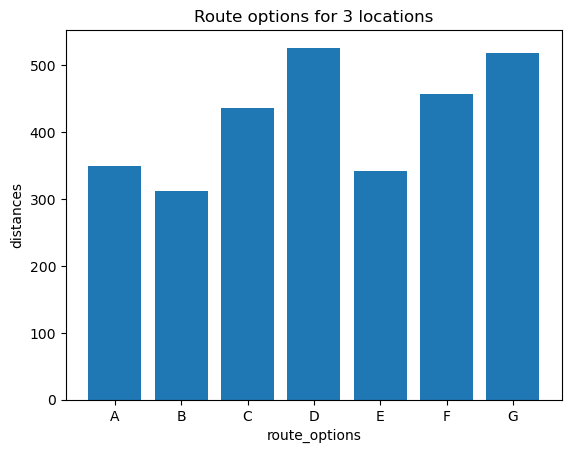

In [9]:
route_options = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
distances = [348.43840970398116, 311.13779846633486, 435.2788812109382, 525.9399631133659, 340.86459287297924, 456.5773622080256, 518.1065638927103]
plt.bar(route_options, distances)
plt.xlabel('route_options')
plt.ylabel('distances')
plt.title('Route options for 3 locations')


#### In the above bar chart we can see that Route D and Route G are covering similar distances. Route D = Buffalo Canyon Trail → Spud Lake Trail → Grizzly Creek Trail. Route G = Riverfront Trail → Riverbend Ponds Natural Area → Bear Lake Loop 

In [10]:
### defing features for nearest neighbors
features = ['latitude', 'longitude']

## Creating Function with help of nearest neighbors

In [11]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors = 5, metric= metric)
    nbrs.fit(df[features].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors(data.iloc[n][features].values.reshape(1,-1), k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [12]:
get_knn(data,7,8, 'haversine')

location_name                           trail_name        sport type  \
7       Fort Collins         Riverbend Ponds Natural Area            Hiking   
2            Boulder                     Chautauqua Trail            Hiking   
0  Rocky Mountain NP                       Bear Lake Loop            Hiking   
4            Durango                      Spud Lake Trail  Hiking & Fishing   
6     Grand Junction                     Riverfront Trail   Hiking & Biking   
1       Maroon Bells        Maroon Lake Scenic Loop Trail            Hiking   
5   Glenwood Springs  Grizzly Creek Trail (first 2 miles)            Hiking   
3   Colorado Springs                 Buffalo Canyon Trail            Hiking   

   latitude  longitude difficulty_level elevation_gain entrance_pass  \
7  40.54560 -105.01290         Beginner        Minimal            No   
2  40.00080 -105.28360         Beginner         200 ft            No   
0  40.31196 -105.64581         Beginner          45 ft           Yes   
4  37.42860 -107.77940         Beginner         100 ft            No   
6  39.07420 -108.55060         Beginner        Minimal            No   
1  39.09991 -106.94192         Beginner         160 ft           yes   
5  39.44750 -107.33000         Beginner         200 ft            No   
3  38.81100 -104.85990         Beginner         150 ft            No   

  gear_needed camping  distance  
7          No      No  0.000000  
2          No      No  0.588142  
0          No     Yes  0.621820  
4          No     Yes  0.675880  
6          No      No  1.096248  
1          No     Yes  1.220262  
5          No      No  1.398433  
3          No      No  1.729584

## Creating data frame with the hiking trails

In [13]:

hiking_location = pd.DataFrame({ 'Trail_name': ["Bear Lake Loop","Maroon Lake Scenic Loop Trail","Chautauqua Trail","Buffalo Canyon Trail","Spud Lake Trail","Grizzly Creek Trail","Riverfront Trail","Riverbend Ponds Natural Area"],
                'Latitude': ["40.31196","39.09991","40.0008","38.8110","37.4286","39.4475","39.0742","40.5456"],
                'Longitude':["-105.64581","-106.94192","-105.2836","-104.8599","-107.7794","-107.3300","-108.5506","-105.0129"]})

hiking_location
hiking_location['Latitude'] = pd.to_numeric(hiking_location['Latitude'], errors='coerce')
hiking_location['Longitude'] = pd.to_numeric(hiking_location['Longitude'], errors='coerce')

## Visualization of base model route 

In [14]:
route_coords = [
    (40.31196, -105.64581), # Bear Lake Loop
    (39.09991, -106.94192), #Maroon Lake Scenic Loop Trail
    (40.0008,-105.2836),  #Chautauqua Trail
    (38.811,-104.8599), #Buffalo Canyon Trail
    (37.4286,-107.7794), #Spud Lake Trail
    (39.4475,-107.33), #Grizzly Creek Trail (first 2 miles)
    (39.0742,-108.5506), #Riverfront Trail
    (40.5456,-105.0129) #Riverbend Ponds Natural Area
]

m = folium.Map(location= [40.31196, -105.64581], zoom_start =5)

for coord in route_coords:
    folium.Marker(location=coord).add_to(m)
# Adding arrows to show direction along the route
for i in range (len(route_coords) -1):
    start= route_coords[i]
    end= route_coords[i + 1]
    plugins.PolyLineOffset(locations= [start, end],color='blue', weight=5, 
                           opacity=0.7, offset=0, dash_array='5,10').add_to(m)
    plugins.BeautifyIcon(icon_shape='arrow', border_color='blue', text_color='blue', icon='arrow-right').add_to(folium.Marker(location=end))
                         
                         
m.save('route_map_with_arrows.html')                      
print("Route map has been saved to 'route_map_with_arrows.html'.")

Route map has been saved to 'route_map_with_arrows.html'.


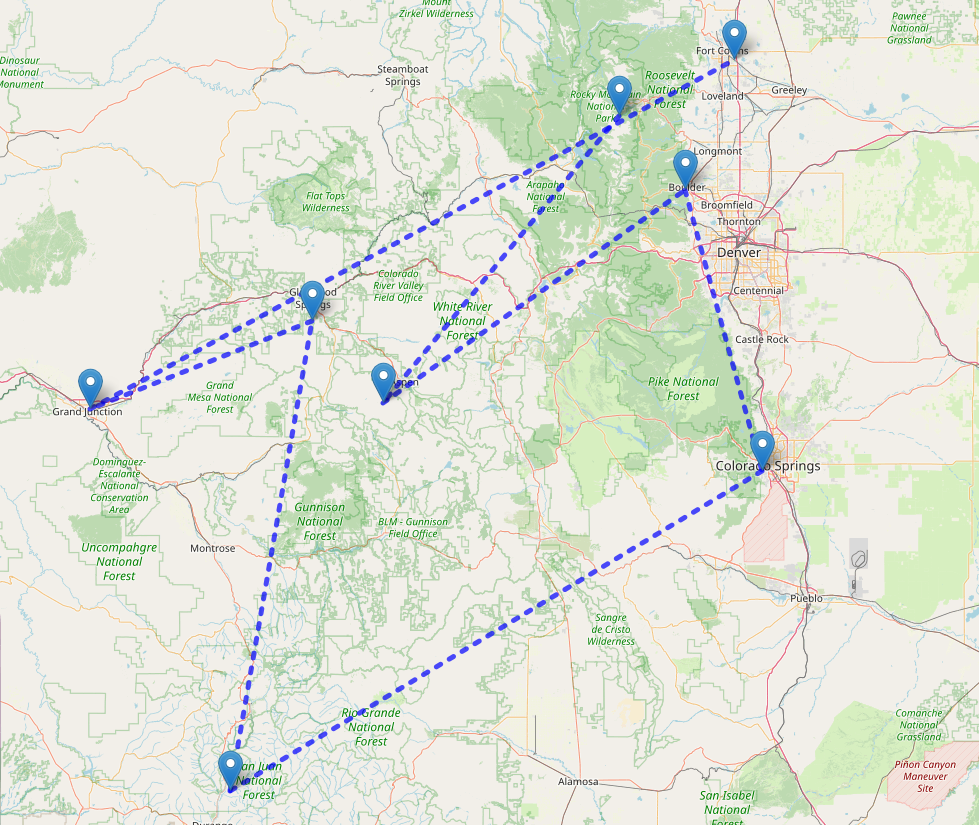

In [15]:
## Displaying base route
img = Image.open('base route_map.png') 
display(img)


## Discussion of base model

## Optimized route

In [16]:
hiking_location['Latitude'] = pd.to_numeric(hiking_location['Latitude'], errors='coerce')
hiking_location['Longitude'] = pd.to_numeric(hiking_location['Longitude'], errors='coerce')

loc_rad = np.radians(hiking_location[['Latitude','Longitude']].values)
nbrs = NearestNeighbors(n_neighbors=len(hiking_location), metric= 'haversine')
nbrs.fit(loc_rad)


loc_visited = [0]
total_distance = 0
loc_current = 0

while len (loc_visited) < len(hiking_location):
    distances, indices = nbrs.kneighbors([loc_rad[loc_current]])
    for ind, dist in zip(indices[0], distances[0]):
        if ind not in loc_visited: 
            loc_visited.append(ind)
            total_distance += dist* 6371 
            current = ind  
total_distance == np.linalg.norm(loc_rad[loc_current] - loc_rad[0]) * 6371
loc_visited.append(0)
print("Total distance of optimized model:",total_distance)
print(loc_visited)

Total distance of optimized model: 1287.3040047325019
[0, 2, 7, 5, 1, 3, 6, 4, 0]


### Visualization of optimized route

In [17]:
import folium
from folium import plugins

route_coords = [
    (40.31196, -105.64581), # Bear Lake Loop
    (40.0008,-105.2836),  #Chautauqua Trail
    (40.5456,-105.0129), #Riverbend Ponds Natural Area
    (39.4475,-107.33), #Grizzly Creek Trail
    (39.09991, -106.94192), #Maroon Lake Scenic Loop Trail
    (38.811,-104.8599), #Buffalo Canyon Trail
    (39.0742,-108.5506), #Riverfront Trail
    (37.4286,-107.7794),  #Spud Lake Trail
    (40.31196, -105.64581), # Bear Lake Loop
]
m = folium.Map(location= [40.31196, -105.64581], zoom_start =5)
for coord in route_coords:
    folium.Marker(location=coord).add_to(m)
# Adding arrows to show direction along the route
for i in range (len(route_coords) -1):
    start= route_coords[i]
    end= route_coords[i + 1]
    plugins.PolyLineOffset(locations= [start, end],color='blue', weight=5, opacity=0.7, offset=0, dash_array='5,10').add_to(m)
    plugins.BeautifyIcon(icon_shape='arrow', border_color='blue', text_color='blue', icon='arrow-right').add_to(folium.Marker(location=end))                                              
m.save('optimized route_map.html')                      
print("Route map has been saved to 'optimized route_map_with_arrows.html'.")

Route map has been saved to 'optimized route_map_with_arrows.html'.


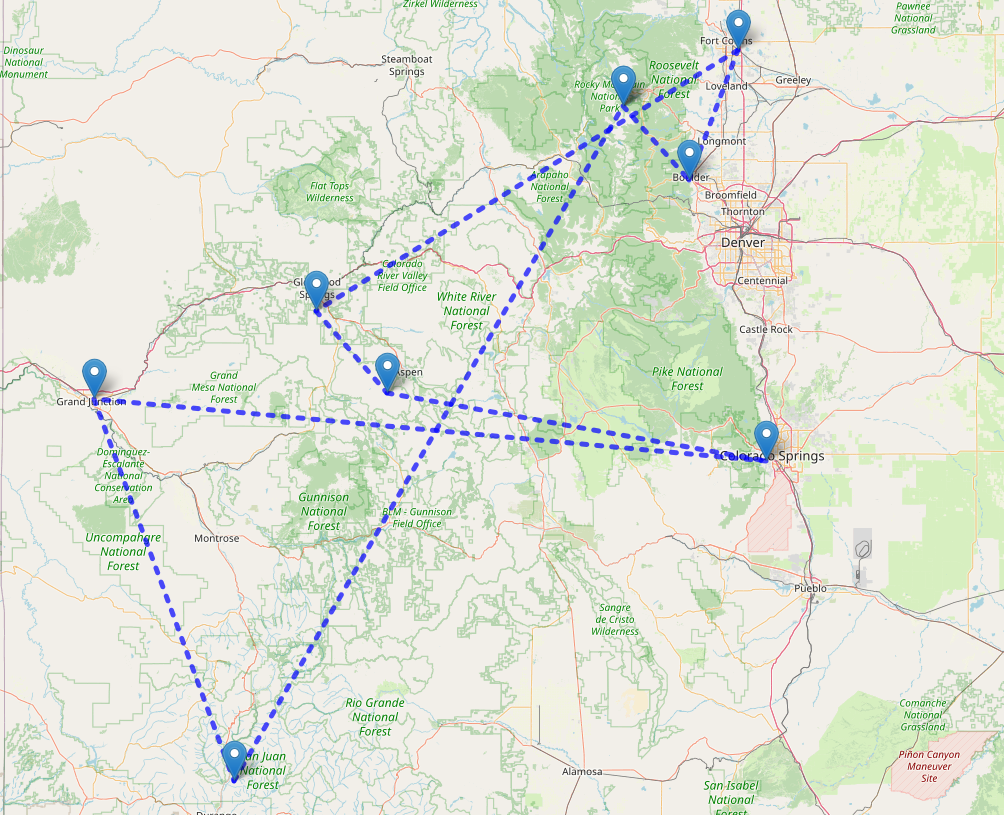

In [20]:
## Displaying Optimized route
img = Image.open(r"C:\Users\Sohin\OneDrive\Documentos\GitHub\July code pudding\images\optimized route_map.png") 
display(img)

## Creation of Optimized Route

This project focuses on developing an algorithm to optimize the route between multiple hiking locations using geospatial data. The goal is to minimize the total travel distance while visiting each location exactly once and returning to the starting point.
The dataset includes latitude and longitude coordinates for various hiking spots. To ensure accurate calculations, the coordinates were converted to numeric format using Pandas with error handling (errors='coerce'). This step ensures that any non-numeric or malformed data is safely handled.
Libraries Used Pandas: For data manipulation and cleaning. NumPy: For mathematical operations and coordinate transformations.Scikit-learn: Specifically the NearestNeighbors class, used to compute distances between locations using the Haversine metric, which is ideal for spherical distance calculations.
Algorithm Description
The algorithm follows a greedy nearest-neighbor approach: Convert all coordinates to radians for Haversine distance calculations.Fit a NearestNeighbors model to the location data. Start from an initial location and iteratively select the nearest unvisited location. Accumulate the distance traveled and mark each location as visited. After all locations are visited, return to the starting point to complete the loop.
Approaches Considered: Several routing strategies were explored: Greedy nearest-neighbor: Efficient and simple to implement, though not guaranteed to find the absolute shortest path. Dijkstra, A which was  more complex and better suited for weighted networks or dynamic routing.
The greedy nearest-neighbor method was selected for its balance between simplicity and performance. While it may not always yield the optimal path, it provides a reasonable approximation with minimal computational overhead, making it ideal for small to medium-sized datasets.

Results
The model outputs the total distance of the optimized route in kilometers and the sequence of visited locations. This provides a practical and efficient solution for planning hiking trips.

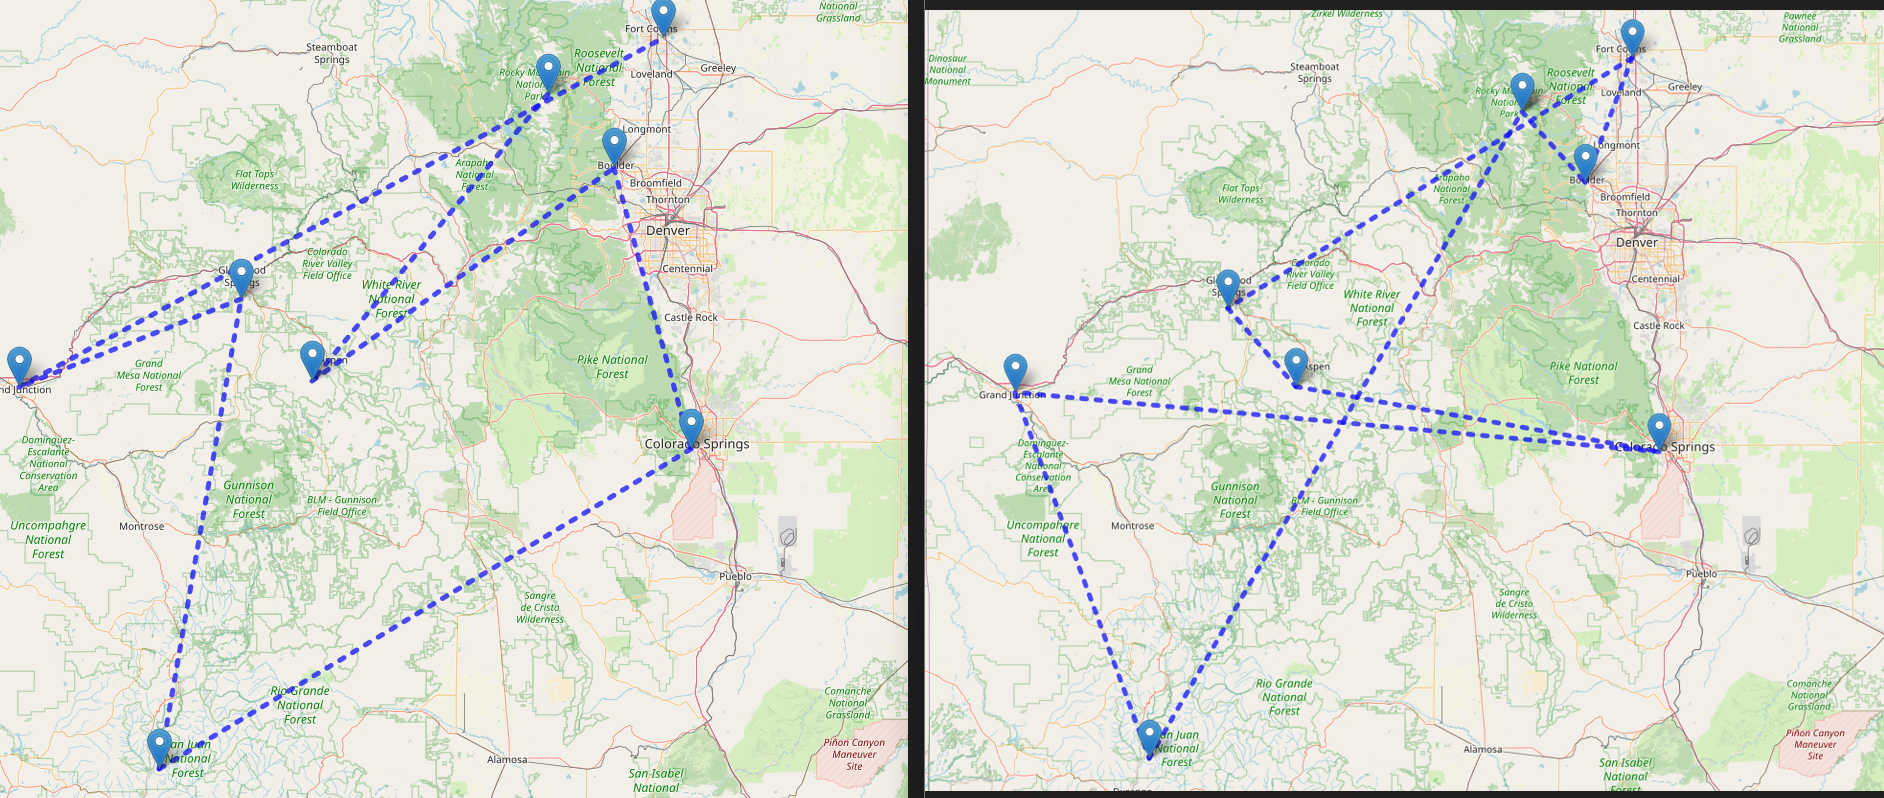

In [ ]:
## Comparing base route and optimized route side by side
img = Image.open('base route vs optimized route.png') 
display(img)

#### The base route is shown on the left, while the optimized route is on the right. In the optimized route, the journey goes directly from Boulder to Rocky Mountain, whereas in the base route, it detours from Boulder to Aspen before reaching Rocky Mountain, adding a few extra kilometers. Additionally, the optimized route travels directly from Grand Junction to the San Juan National Forest, unlike the base route, which takes a less direct path.

## Conclusion and Recommendations

### This project demonstrates how data science and geospatial analytics can be effectively applied to support strategic planning in adventure-based tourism. By analyzing nine key recreational locations across Colorado, we integrated environmental, geographic, and activity-based data to evaluate route efficiency, terrain suitability, and spatial distribution. Visual tools such as interactive maps, elevation profiles, and sunburst charts provided intuitive insights into terrain variation and regional clustering.The comparison between a fixed base route and an optimized route using a nearest-neighbor algorithm revealed significant improvements in travel efficiency. The optimized model offered more direct paths between destinations, reducing overall distance and enhancing trip planning for multi-activity outdoor experiences.

### Recommendations for Future Research - To build upon this work, we suggest the following directions for future research:
#### Incorporate Real-Time Data: Integrate live weather, traffic, and trail condition data to enhance route planning and safety considerations.
#### Expand Activity Types and Seasons: Include seasonal variations and a broader range of activities (e.g., snowshoeing, paragliding, camping) to support year-round tourism planning.
#### Use Advanced Optimization Algorithms: Explore more sophisticated routing algorithms such as genetic algorithms, ant colony optimization, or mixed-integer programming for potentially better route efficiency.
#### Include Environmental Impact Metrics: Assess the ecological footprint of each route to promote sustainable tourism and minimize environmental degradation.
#### User-Centric Personalization: Develop models that tailor routes based on user preferences, fitness levels, or accessibility needs.
#### Economic and Social Impact Analysis: Evaluate how optimized tourism routes could influence local economies, infrastructure, and community engagement.
#### Mobile App Integration: Translate the model into a user-friendly mobile application for real-time route planning and navigation.